# Notebook for moisture transport project 

**TO DO**

- get hourly data for all variables (new hard disk?)
- solve diagnostic calculation of moisture divergence


**First steps**
- create timeseries with anomalies for P, E and moisture transport (MFC)
- wavelet analysis on hourly precip data 
- decomposition of MFC in eddy and mean flow 
- decomposition in thermodynamic and dynamic component 


**Next steps:**
- do the same for WRF or HAR data 
- do the same for extreme events on different time scales 
- do the same events for extreme events on different spatial scales 


##  vertically integrated moisture flux divergence from q and wind fields 

- get moisture divergent fields for every single summer season and calculate the mean of divergences 
- column integration of divergence fields 
- deviation to monthly means for eddy decomposition 
- from mixing ratio/specific humidity (kg/kg) to mm/day (or kg/m3) using density of dry air: pd = p/RT (ideal gas law )

## Calculation functions

In [2062]:
# import libraries 
import numpy as np 
import xarray as xr
import metpy 
from metpy import calc
import scipy as sp
import scipy.signal
from scipy.signal import convolve


**Basics**

In [2028]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def geopotential_to_height(z):
    """ This function converts geopotential heights to geometric heights. This approximation takes into account the varying gravitational force with heights, but neglects latitudinal vairations.
    Parameters:
    ------------
    z(float) : (1D or multi-dimenstional) array with geopotential heights
    Returns:
    ----------
    geometric_heights : array of same shape containing altitudes in metres
    """
    g = 9.80665 # standard gravity 
    Re = 6.371 * 10**6  # earth radius
    geometric_heights   = (z*Re) / (g * Re - z)
    return geometric_heights 


def column_integration(values, z, ax = None ):
    """This functions calculates the column-integrated value of a given atmospheric variable at different pressure levels
    Parameters:
    -----------
    values(float): 1D or multi-dimensional array with values of atmospheric variable at different pressure levels
    z(int): array with geopotential heights for values
    axis = axis along which to integrated. The default is 0.
    Returns:
    --------
    colint(float): array with column-integrated values of variable (dimension reduced by 1)
    """
    # convert geopotential to geometric heights in meters 
    geometric_heights   = geopotential_to_height(z)

    if ax == None:
        ax = 0

    # integration of column values
    colint = np.trapz(values, x= geometric_heights, axis =ax )

    return colint

**Constants**

In [2059]:
from metpy.units import units

# assign unit to grid spacing
Rad = 6371*1000
# gravitational accelration 
g = 9.8 
# density of water in kg/m3 
pw= 997
# density for dry air 
pd = 1.225 
# specific gas constant for dry air 
R = 287.058

## grid spacings 
dx = 2*np.pi*Rad * (0.25/360)
# latitude dependent 
dy = 2*np.pi*Rad *(0.25/360) * np.cos(np.nanmean(lats))*(-1)
dx = dx * units.meters
dy = dy * units.meters
# constant for unit in mm per day 
C= -1/(g*pw)
c= -1/(g)

**Divergence**

In [2639]:
## preprocessing of coordinates for convolution 

# creating 2D fields for lats and lons 
latitudes = np.stack([lats]*np.shape(lons)[0], axis = 1)
longitudes = np.stack([lons]*np.shape(lats)[0], axis = 0)

# convert lats and lons to cartesian coordinates 
x = Rad * np.cos(np.radians(latitudes)) * np.cos(np.radians(longitudes))
y = Rad * np.cos(np.radians(latitudes)) * np.sin(np.radians(longitudes))
z = Rad *np.sin(np.radians(latitudes))

# stack to get 3D array 
cartesian = np.stack([x, y, z], axis = 2)
# pythagorean theorem to get distances in meter
dlat = np.sqrt(np.sum((cartesian[2:, :] - cartesian[:-2,:]) ** 2, axis=-1))
dlon = np.sqrt(np.sum((cartesian[:, 2:] - cartesian[:,:-2]) ** 2, axis=-1))


In [3000]:
# with convolution 

def dy_dlat(y, dlat):
    k_lat = np.array([[1], [0], [-1]])
    result = convolve(y, k_lat, mode="valid") / dlat
    return result 

def dy_dlon(y, dlon):
    k_lon= np.array([[-1, 0, 1]])
    result = convolve(y, k_lon, mode="valid") / dlon
    return result 

## Climatological precipitation and evaporation ERA5 

In [3039]:
f= 'cache/era5_monthlymean_clim_precip.nc'
precip = xr.open_dataset(f)
P = precip.tp.values[0]*1000
f= 'cache/era5_monthlymean_clim_evapo.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values[0]* - 1000
f= 'cache/era5_monthlymean_clim_moistdiv.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values[0] * 86400
vimd = moisture['vimd'].values[0] 

# check P - E which should be equal to moisture flux divergence 
p_e = P - E 

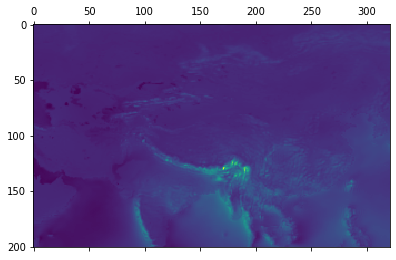

In [3045]:
plt.matshow(-vimd, p_e.min(), vmax = p_e.max())

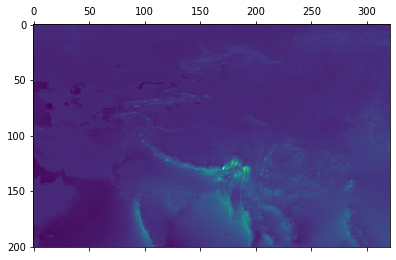

In [3044]:
plt.matshow(p_e, vmin = p_e.min(), vmax = p_e.max())

**Comparison of total sums**

In [2262]:
np.nansum(moistdiv)

-83687.21491231117

In [2261]:
np.nansum(p_e)

85833.61

In [2260]:
np.nansum(vimd)

-90482.31

In [3086]:
# from all years
np.nansum(moist_div)

-31975.445

In [3085]:
# from all years 
np.nansum(flux_div)

-19065.40686281296

In [2005]:
## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
la = elevations.lat.values
lo = elevations.lon.values

In [2180]:
# summer climatology 

f = 'cache/temp.nc'
data = xr.open_dataset(f)
temp = data.t[0]

f = 'cache/era5_summerclim.nc'
mfields = xr.open_dataset(f)
u = mfields.u[0]
v = mfields.v[0]
q = mfields.q[0] 
z = mfields.z[0]

lats= mfields.latitude
lons = mfields.longitude
pressure = mfields.level.values

# get qV field 
qu = q*u 
qv = q*v

## 3. Temporal average over summer seasons 1979 to 2019 

In [1401]:
quint = np.zeros(np.shape(q[2]))
qvint  = np.zeros(np.shape(q[2]))

i= 0
for y in np.arange(1979,2020):
    i+= 1
    f = 'cache/era5_'+str(y) +'_fields_monmean.nc'
    s = 'cache/era5_'+str(y) +'_clwcciwc.nc'
    t = 'cache/era5_'+str(y) +'_temp.nc'
    # get variables 
    mfields = xr.open_dataset(f)
    sfield = xr.open_dataset(s)
    tfield = xr.open_dataset(t)
    u = mfields.u[0]
    v = mfields.v[0]
    # specific humidity (water vapour in kg/kg)
    q = mfields.q[0] 
    # add specific cloud water and specific cloud ice to get full water 
    clwc = sfield.clwc[0]
    ciwc = sfield.ciwc[0] 
    q = q +  clwc + ciwc 
    
    z = mfields.z[0] 
    lats= mfields.latitude
    lons = mfields.longitude
    pressure = mfields.level.values
    t= tfield.t[0]
    
    #convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(0,7):
        pd = pressure[plev]/R*temp[plev]
        moisture = q[plev] *pd
        q[plev] = moisture 
    q = q* pd 
        
    # get qV fields 
    qu = q*v
    qv = q*u
    
    # colummn integration 
    quint = column_integration(qu, z)
    qvint = column_integration(qv, z)
    
    
    # close open datasets 
    mfields.close()
    sfield.close()

    # horizontal divergence (unit: kg/m2/s) 
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udev = np.hstack([udev,np.zeros((201,2))])
    vdev = np.vstack([vdev, np.zeros((2,321))])
    # sum derivatives along x and y axis to get divergence 
    moisture_field += udev + vdev
    
moisture_field = moisture_field/41
    


## Example: May 1979 

In [3081]:
# Verification: vertically integrated moisture and moisture flux divergence 

f = 'cache/era5_single-levels-monthly-means_1979_months5_mvimdvimdvertical_integral_of_divergence_of_moisture_fluxdivergence_60,50,10,130.nc'
divergence = xr.open_dataset(f)
flux_div = divergence['p84.162'][0] * 86400# mean 
moist_div = divergence['vimd'][0] # accumulated 

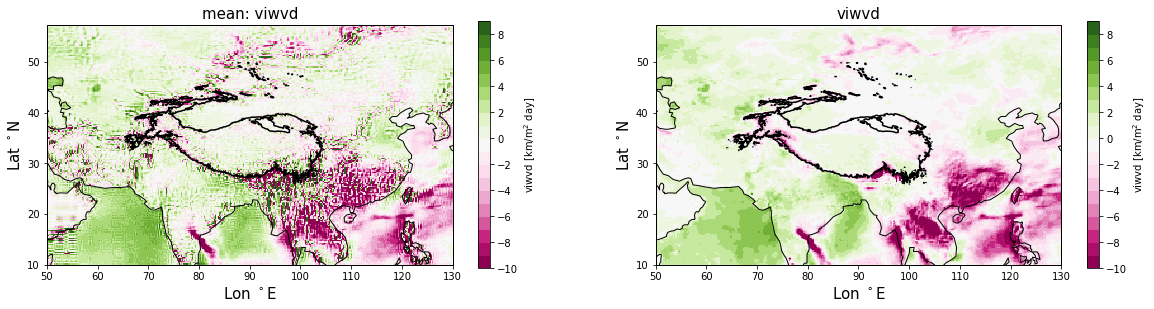

In [3056]:
plt.figure(figsize= (20,10))
s= 15

ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m1= ax1.pcolormesh(lons, lats, flux_div,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=s)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=s)
ax1.set_title('mean: viwvd', fontsize= s)
plt.colorbar(m1, label = 'viwvd [km/m$^2$ day]')


ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m2= ax2.pcolormesh(lons, lats, moist_div, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_title('viwvd', fontsize= s)
ax2.set_ylabel('Lat $^\circ$N',  fontsize= s)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=s)
plt.colorbar(m2, label = 'viwvd [km/m$^2$ day]')
plt.savefig('ERA5_vimd_and_viwvd.png')
plt.show()

In [3159]:
f = 'cache/era5_1979_may.nc'
# get variables 
mfields = xr.open_dataset(f)
u = mfields.u[0]
v = mfields.v[0]
# specific humidity (water vapour in g/kg)
sh = mfields.q[0] 
# get geopotential 
z = mfields.z[0].values

# get fields for cloud ice and water 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_ciwvclwc_60,50,10,130.nc'
d = xr.open_dataset(f)
ciwc = d.ciwc[0]
clwc = d.clwc[0]

# effect of surface pressure
f = 'cache/era5_single-levels-monthly-means_1979_months5_surface_pressure_60,50,10,130.nc'
d = xr.open_dataset(f)
sp = d.sp[0].values/100

# temperature for unit conversion 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_temperature_60,50,10,130.nc'
d = xr.open_dataset(f)
temp = d.t[0].values

q = sh + ciwc + clwc 

In [3058]:
# set geopotential to 0, where surface pressure < 1000 hpa 
coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = find_nearest_idx(pressure, sp_value)
    if sp_value > pl:
        idx = idx + 1     
    # set q value below ground to 0 
    q[idx:36, ilat, ilon] = 0

In [3059]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*temp[plev])
    m = q[plev] *p_d
    q[plev] = m 

In [3161]:
# get qv fields 
qu = q*u
qv = q*v

# colummn integration of q and wind fields 
quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

# horizontal divergence
udev = dy_dlon(quint, dlon) 
vdev = dy_dlat(qvint, dlat) 
udiv = np.hstack([udev,np.zeros((201,2))])
vdiv = np.vstack([vdev, np.zeros((2,321))])

# sum derivatives along x and y axis to get divergence 
div= (udiv + vdiv ) 
# x 1/g and conversion to mm per day 
divergence = div * 86400 * c 

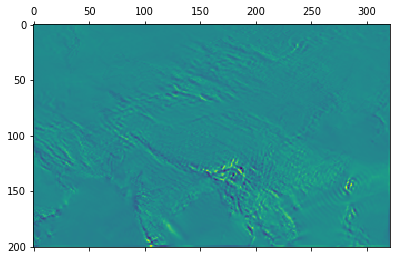

In [3071]:
plt.matshow(div)

In [3062]:
div.sum()

-2741.845595370675

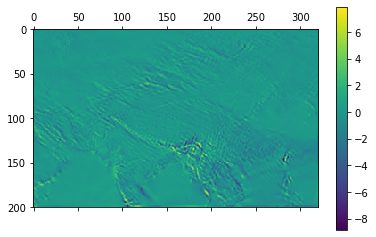

In [3063]:
# lon index 
plt.matshow(div)
plt.colorbar()

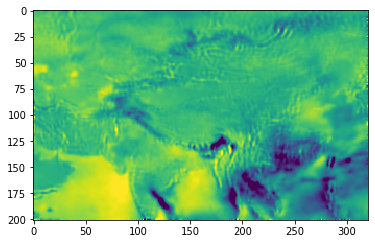

In [2854]:
smoothed = wrf.smooth2d(flux_div, passes = 5)
plt.imshow(smoothed, vmin = -10, vmax = 5)

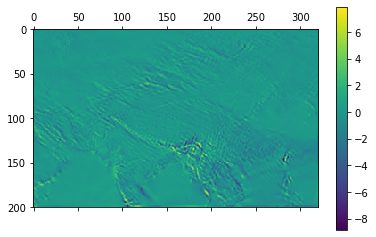

In [2980]:
plt.matshow(divergence)
plt.colorbar()

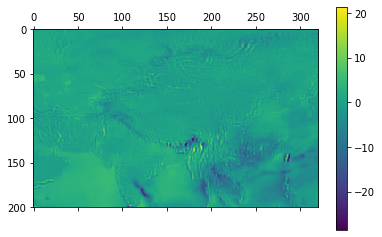

In [2982]:
smoothed = wrf.smooth2d(flux_div*86400, passes = 2)
plt.matshow(smoothed)
plt.colorbar()

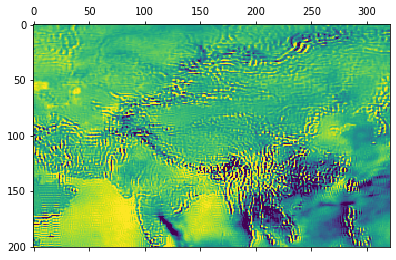

In [2830]:
plt.matshow(flux_div, vmin  = -10, vmax =5)
plt.show()

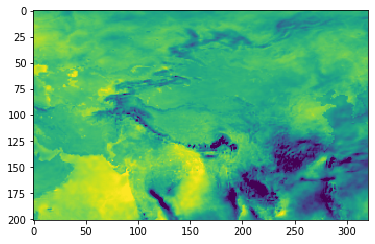

In [2831]:
plt.imshow(moist_div, vmin = -10, vmax = 5)

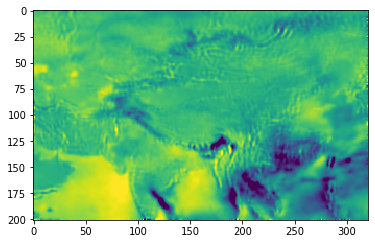

In [2475]:
import wrf 
smoothed = wrf.smooth2d(flux_div, passes = 5)
plt.imshow(smoothed, vmin = -10, vmax = 5)

In [2572]:
# with metpy derivate function instead of convolution 
u_d = metpy.calc.first_derivative(quint[:,:-1], axis =  -1, delta = dlon* units.meter) 
v_d = metpy.calc.first_derivative(qvint[:-1,:], axis = -2, delta = dlat* units.meter)

u_d = np.hstack([udev,np.zeros((201,2))])
v_d = np.vstack([vdev, np.zeros((2,321))])

md = ( u_d + v_d)*86400*c


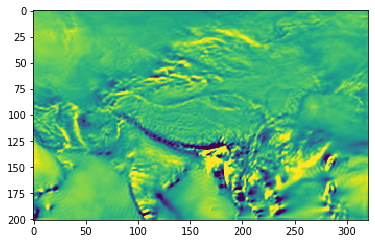

In [2676]:
plt.imshow(div, vmin = -10, vmax = 5)

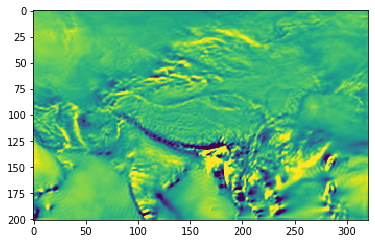

In [2675]:
plt.imshow(-md, vmin = -10, vmax = 5)

-> same result for divergences calculated with convolution for first derivative functions rovided by metpy! 

## May 1979 from hourly data

In [3088]:
# VIMD from may 1979 ERA5 averaged 

file = 'cache/era5_single-levels-monthly-means_1979_months5_vimd_60,50,10,130.nc'
fields = xr.open_dataset(file)
vimd = fields.vimd[0] 

In [3117]:
# file with hourly values for pressure levels 
hourly = 'cache/era5_pressure-levels_1979_months5_geopotentialspecific_humidityu_component_of_windv_component_of_wind_60,50,10,130.nc'
# get variables 
mfields = xr.open_dataset(hourly)
udata = mfields.u
vdata = mfields.v
# specific humidity (water vapour in g/kg)
qdata = mfields.q
# get geopotential 
zdata = mfields.z.values

# get hourly temperatures 
temp_hourly = 'cache/era5_pressure-levels-monthly-means_1979_months5_temperature_60,50,10,130.nc'
tempfield = xr.open_dataset(temp_hourly)
th = tempfield.t.values


In [3156]:
# get hourly surface pressure data 
hourly_sp = 'cache/era5_single-levels_1979_months5_surface_pressure_60,50,10,130.nc'
spdata = xr.open_dataset(hourly_sp)['sp'].values / 100

In [3162]:
# initiate array for divergences 
div_accum = np.zeros((201,321))

for t in np.arange(744):
    q= qdata[t,:,:,:]
    u= udata[t, :, :, :]
    v = vdata[t, :, :, :]
    z= zdata[t, :, :, :]
    sp = spdata[t, :, :]

        
    # get qv fields 
    qu = q*u
    qv = q*v

    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # horizontal divergence
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev,np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    div_accum += (udiv + vdiv)


In [3135]:
# initiate array for divergences without Z correction 
div_noZ = np.zeros((201,321))

for t in np.arange(744):
    q= qdata[t,:,:,:]
    u= udata[t, :, :, :]
    v = vdata[t, :, :, :]
    z= zdata[t, :, :, :]
    sp = spdata[t, :, :]
    
    # get qv fields 
    qu = q*u
    qv = q*v

    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # horizontal divergence
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev,np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    div_noZ += (udiv + vdiv)


In [ ]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*th[plev])
    m = q[plev] *p_d
    q[plev] = m 
        

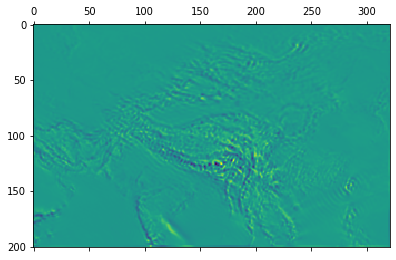

In [3163]:
# accumulated divergence field 
plt.matshow(div_accum)

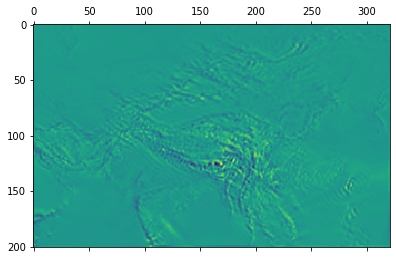

In [3164]:
plt.matshow(div)

In [3170]:
diva = div_accum/744

In [3176]:
diva.sum()

0.09741061940950238

In [3175]:
div.sum()

0.1970186430145256

## Plot water balance 

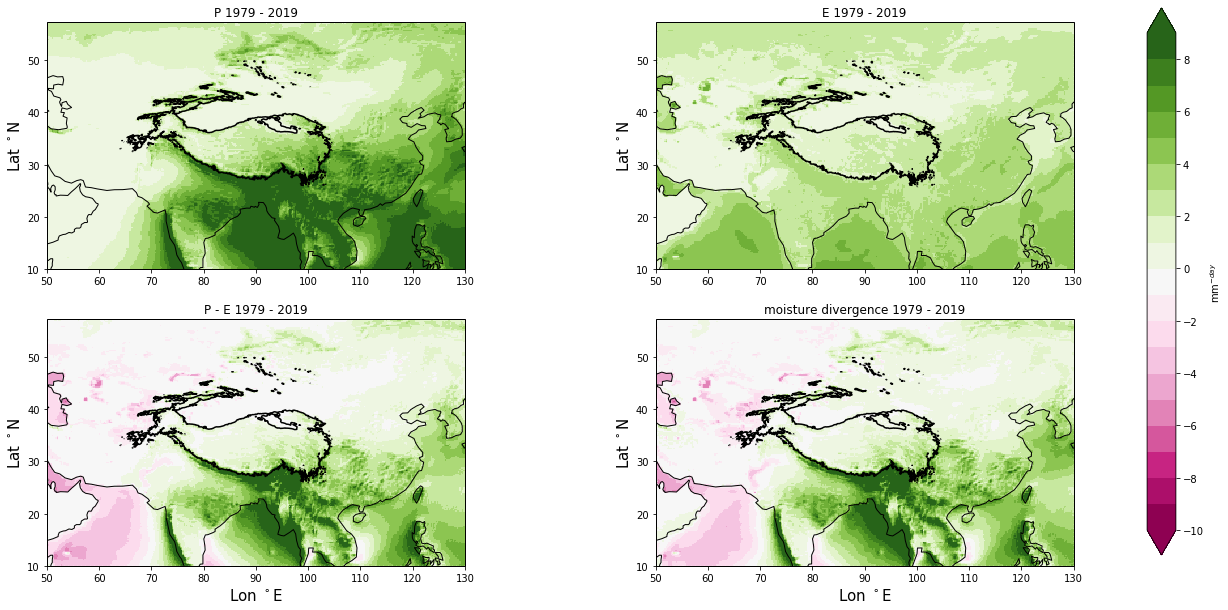

In [2270]:
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors


fig =plt.figure(figsize=(20,10))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

# customizing of colorbar 
cmap=plt.cm.PiYG
#cmap=plt.cm.coolwarm
r = np.arange(-10,10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values


# P
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax1.pcolormesh(lons, lats, P,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title('P 1979 - 2019')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=15)


# E
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax2.pcolormesh(lons, lats, E, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title('E 1979 - 2019')
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=15)


# P - E
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax3.pcolormesh(lons, lats, p_e, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title('P - E 1979 - 2019')
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=15)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=15)



# moist div 
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m = ax4.pcolormesh(lons, lats, -vimd, cmap = cmap ,norm = norm )
ax4.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines(color = 'black')
ax4.set_title('moisture convergence 1979 - 2019')
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=15)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=15)


cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm$^{-day}$')

plt.savefig('plots/P_E_moisture_budget_era5.png')
plt.show()

## Decomposition in thermodynamic and dynamic component

## Time series of P, E and moisture transport 

Is summer precipitation variability dominated by moisture transport (remote controls) or by evaporation anomalies (local controls)? 

In [2050]:
f= 'cache/precip_timeseries.nc'
precip = xr.open_dataset(f)
P = precip.tp.values*1000
f= 'cache/evapo_timeseries.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values*-1000
f= 'cache/moistdiv_timeseries.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values
x = np.arange(1979,2019)

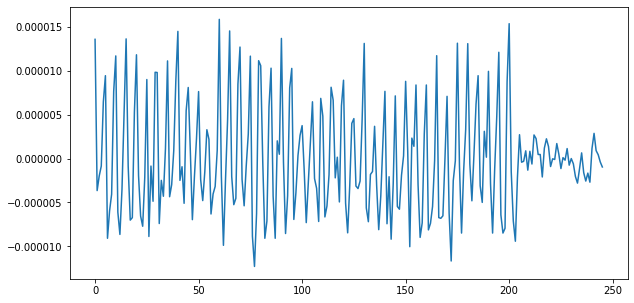

In [2053]:
p_clim = np.mean(P[:,0,0])
e_clim = np.mean(E[:,0,0])
m_clim = np.mean(moistdiv[:,0,0])

plt.figure(figsize= (10,5))

plt.plot(moistdiv[:,0,0] - m_clim)
plt.show()

# Verifications...

## divergence of wind to test divergence calculation 

In [2719]:
# read in divergence of wind 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_divergence_of_wind_60,50,10,130.nc'
d = xr.open_dataset(f)['d'][0]

# read in u and v values at pressure levels for same month 
data = 'cache/era5_pressure-levels-monthly-means_1979_months5_uvspecific_humidity_60,50,10,130.nc'
fields = xr.open_dataset(data)
u  = fields.u[0]
v  = fields.v[0]


In [2791]:
# choose specific level to look at 
d_lev = d[20, :, :]
u_lev = u[20, :, :]
v_lev = v[20,:, :]


64378221.736385345

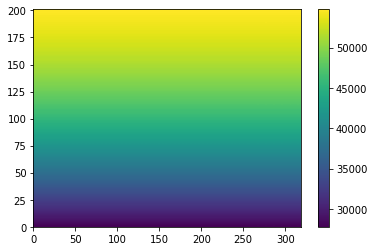

In [2797]:
plt.pcolormesh(dlon)
plt.colorbar()
np.var(dlon)

In [2814]:
# horizontal divergence
udev = dy_dlon(u_lev, dlon) 
vdev = dy_dlat(v_lev, dlat) 
udiv = np.hstack([udev, np.zeros((201,2)) ])
vdiv = np.vstack([vdev, np.zeros((2,321)) ])

# add 
div_wind = udiv - vdiv

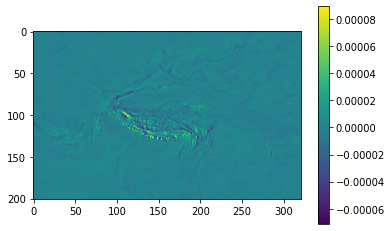

In [2815]:
plt.imshow(d_lev)
plt.colorbar()

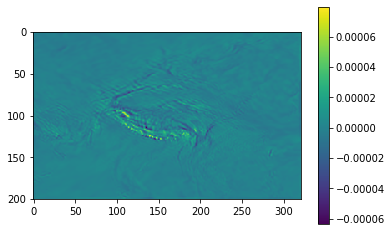

In [2817]:
plt.imshow(-div_wind)
plt.colorbar()

## test total water column integration 


The column integration function is tested here. Note that two important steps need to e done: 

1. setting z values below surface pressure to 0 
2. convert units of specific humidity from kg/kg to kg/m3

In [2041]:
# total column water vapor and divergence
f = 'cache/era5_single-levels-monthly-means_1979_months5_total_column_water_vapourdivergence_60,50,10,130.nc'
d = xr.open_dataset(f)
tcwv = d.tcwv[0].values

# specific humidity 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_uvspecific_humidity_60,50,10,130.nc'
sh = xr.open_dataset(f)
q = sh.q[0].values

# geopotential
f = 'cache/era5_1979_may.nc'
z = xr.open_dataset(f)
z = z.z[0].values

# surface pressure 
f = 'cache/era5_single-levels-monthly-means_1979_months5_surface_pressure_60,50,10,130.nc'
sp = xr.open_dataset(f)
sp = sp.sp[0].values / 100


# temperature 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_temperature_60,50,10,130.nc'
t = xr.open_dataset(f)
t = t.t[0].values

In [2073]:
f = 'cache/era5_single-levels-monthly-means_1979_months5_total_column_water_vapourdivergence_60,50,10,130.nc'
d = xr.open_dataset(f)


In [2172]:
# set z to 0 where surface pressure< 1000 hpa 
coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = find_nearest_idx(pressure, sp_value)
    if sp_value > pl:
        idx = idx + 1   
    # set q value below ground to 0 
    q[idx:36, ilat, ilon] =  0

In [2173]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    m = q[plev] *p_d
    q[plev] = m

In [2175]:
# column integration of q 
q_integrated = column_integration(np.flip(q, axis = 0 ), np.flip(z , axis = 0 ), ax = 0)

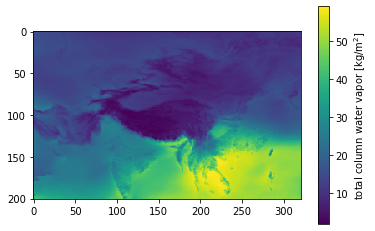

In [2079]:
plt.imshow(q_integrated, vmin = tcwv.min(), vmax = tcwv.max())
plt.colorbar(label = 'total column water vapor [kg/m$^2$]')
plt.savefig('column_wv_calculated.png')
plt.show()

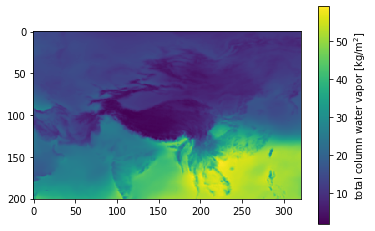

In [2080]:
plt.imshow(tcwv,vmin = tcwv.min(), vmax = tcwv.max())
plt.colorbar(label = 'total column water vapor [kg/m$^2$]')
plt.savefig('column_wv_output.png')
plt.show()